In [12]:
from util import *
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data
Loading from preprocessed numpy array

# Creating GAN

In [121]:
class LSTMGAN():
    def __init__(self, step_i, step_o, f, data):
        self.data = data
        self.step_input = step_i
        self.step_output = step_o
        self.feature_len = f
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50, log_interval=50):
    

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.step_input, self.step_output, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_scale(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)



            # Plot the progress
            if log_interval and epoch % log_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                print("input:\n", scalers[0].inverse_transform( real_input[0]))
                print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
                print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [122]:
data = load_data("./data_stock/SP500_average.csv")
step_i = 5
step_o = 5
f = 4
lstmgan = LSTMGAN(step_i, step_o, f , data)
lstmgan.train(epochs=10000, batch_size=50, save_interval=1000, log_interval=1000)

0 [D loss: 5.110792, acc.: 50.00%] [G loss: 13.447720]
input:
 [[3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]
 [3136.13 3141.16 3108.03 3113.49]
 [3131.   3153.45 3076.06 3124.74]]
fake_output:
 [[3120.4258 3138.389  3087.853  3113.87  ]
 [3120.4822 3137.7634 3087.8975 3113.8403]
 [3120.6265 3138.2893 3087.8926 3114.0005]
 [3120.689  3138.0537 3087.9524 3113.8303]
 [3120.3774 3138.0093 3087.969  3114.082 ]]
real_output:
 [[2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]
 [3213.32 3222.71 3193.11 3207.18]]
1000 [D loss: 0.580173, acc.: 65.90%] [G loss: 6.204760]
input:
 [[2782.46 2782.46 2721.17 2761.63]
 [2776.99 2818.57 2762.36 2789.82]
 [2685.   2760.75 2663.3  2749.98]
 [2738.65 2756.89 2657.67 2659.41]
 [2578.28 2676.85 2574.57 2663.68]]
fake_output:
 [[2874.602  2825.0244 2876.9338 2836.3826]
 [2804.4646 2719.7876 2652.5671 2816.7214]


Loading pretrained model

Installinging Mido Library

# Generate Stock Prices
Generating random input and letting model predict output

In [123]:
import importlib
importlib.reload(util)
from util import *

(real_input, real_output) = split_time_series_disjoint(step_i, step_o, data)
MA5 = moving_average(5, data)
MA5 = MA5[:round(len(MA5)/step_o) * step_o]
(stzd_input, scalers) = batch_standardize(real_input)

stzd_pred_output = lstmgan.generator(tf.convert_to_tensor(stzd_input)).numpy()

#TODO: fix MA5
pred_output = batch_inverse_transform(stzd_pred_output, scalers)
stzd_real_output = batch_transform(real_output, scalers)
stzd_MA5 = batch_transform(MA5.reshape(-1, step_o, MA5.shape[-1]), scalers)

print(f'predicted price:\n{pred_output[0]},\nreal price:\n{real_output[0]},\nMA5:\n{MA5[:5]} \
       ,\nstandardized predicted price:\n{stzd_pred_output[0]} \
       ,\nstandardized real price:\n{stzd_real_output[0]} \
       ,\nstandardized MA5:\n{stzd_MA5[:5]}')

predicted price:
[[4549.987  4602.288  4522.657  4518.8726]
 [4527.137  4607.0312 4508.367  4515.408 ]
 [4536.706  4602.2695 4509.584  4503.0386]
 [4528.708  4597.2095 4504.784  4516.55  ]
 [4528.451  4573.2563 4498.7427 4496.5034]],
real price:
[[4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]],
MA5:
[[4465.944 4507.308 4382.644 4436.002]
 [4519.064 4551.554 4438.962 4480.134]
 [4575.398 4601.11  4517.388 4530.678]
 [4627.834 4651.032 4568.378 4582.896]
 [4664.082 4680.376 4614.13  4631.62 ]]        ,
standardized predicted price:
[[0.90165174 1.0984484  1.2209585  1.3105559 ]
 [0.6565097  1.1533021  1.0963452  1.2557658 ]
 [0.75917083 1.0982323  1.1069539  1.0601507 ]
 [0.6733663  1.0397171  1.0651003  1.2738241 ]
 [0.67061025 0.7626959  1.0124145  0.95679784]]        ,
standardized real price:
[[1.78410733 1.44484439 1.62246542 2.23154782]
 [1.84579622 1.82521

# Plot


In [125]:
#transform everything into columns                
stzd_pred_data = columnify(stzd_pred_output)
stzd_real_data = columnify(stzd_real_output)
stzd_MA5_data = columnify(stzd_MA5)
pred_data = columnify(pred_output)
real_data = columnify(real_output) 
MA5_data = columnify(MA5)

titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)

mae = MAE(stzd_real_data[3],stzd_pred_data[3])
rmse = RMSE(stzd_real_data[3],stzd_pred_data[3])
mape = MAPE(stzd_real_data[3],stzd_pred_data[3])
ar = AR(stzd_real_data[3],stzd_pred_data[3])

MA5_mae = MAE(stzd_real_data[3],stzd_MA5_data[3])
MA5_rmse = RMSE(stzd_real_data[3],stzd_MA5_data[3])
MA5_mape = MAPE(stzd_real_data[3],stzd_MA5_data[3])
MA5_ar = AR(stzd_real_data[3],stzd_MA5_data[3])

print('LSTM: MAE=',mae,'RMSE=',rmse,'MAPE=',mape,'AR=',ar)
print('MA5: MAE=',MA5_mae,'RMSE=',MA5_rmse,'MAPE=',MA5_mape,'AR=',MA5_ar)


LSTM: MAE= 1.1926348656639225 RMSE= 1.7985981823567345 MAPE= 2.6450392414200476 AR= 0.4223093366118731
MA5: MAE= 1.7557341245213265 RMSE= 2.5236634331485277 MAPE= 1.194750537407525 AR= 0.24972417499029


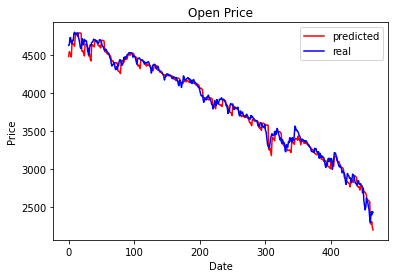

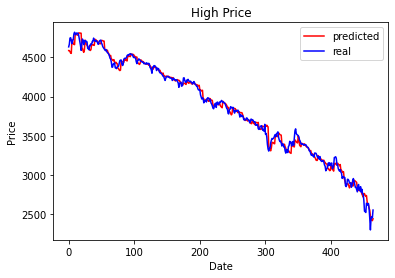

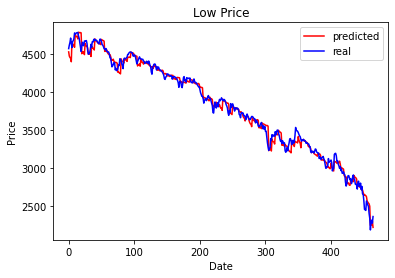

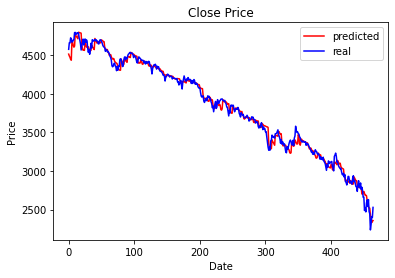

In [66]:
for i in range(columns):
    length = len(pred_data[i])
    plt.plot(range(length), pred_data[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), real_data[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()